In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from data_processing import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from data_transformar import *
import lightgbm as lgb
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor, Pool

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

In [20]:
from sklearn.metrics import mean_squared_error

answers = pd.read_csv("./result-with-best.csv")

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def answers_score(model):
    print("RMSLE sub: " + str(rmsle(model.predict(validation), np.log1p(answers["SalePrice"]))))

def evaluate(model, X, y):
    preds = model.predict(X)
    print("RMSLE: " + str(rmsle(preds, y)))

In [14]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])
#data = remove_outliers(data)

Int64Index([249, 313, 335, 523, 706, 1298], dtype='int64')


In [15]:
y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

(1454, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98987)

In [17]:
X_train_orig = X_train.copy()

transformer = DataTransformer(StandardScaler())

X_train = transformer.prepare(X_train)
X_test = transformer.prepare(X_test)

transformer.fit(X_train)

X_train = transformer.transform(X_train, True, True)
X_test = transformer.transform(X_test, True, True)

(1163, 36) (1163, 278)
(291, 36) (291, 278)


In [18]:
print(X_train.isnull().sum().sum())
X_train.head()

0


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,268,269,270,271,272,273,274,275,276,277
0,-0.284468,-0.914828,-0.736211,-0.064773,1.315237,-1.489457,-0.565665,-1.012857,-0.285104,0.715367,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.068738,0.369772,0.399284,0.652661,-0.501414,0.996677,-0.565665,0.517566,-0.285104,-0.657973,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.873146,1.300000,-0.028030,-0.064773,0.406911,-0.229816,0.398496,-0.562462,1.986686,0.921595,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.166733,-0.249927,-1.098791,-0.064773,2.223562,-1.489457,-0.565665,0.062576,-0.285104,-0.494804,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.166733,-0.471862,-0.352053,-1.499640,0.406911,-0.561300,-0.565665,-1.012857,-0.285104,0.844543,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
#answers sheet
validation = pd.read_csv("./test.csv")
val_ids = validation["Id"]
validation = validation.drop(columns=["Id"])
validation_orig = validation.copy()
validation = transformer.prepare(validation)

validation = transformer.transform(validation, True, True)

(1459, 36) (1459, 278)


In [4]:
from sklearn import linear_model
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import fbeta_score, make_scorer
random_state = 42

def rmse_scorer(clf, X, y):
    return rmsle(clf.predict(X), y)

In [73]:
space = {'alpha': hp.loguniform('alpha', -5, -2),}
trials = Trials()

def objective(params):

    clf = linear_model.Lasso(random_state=random_state,max_iter = 600, **params)

    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring=rmse_scorer)
    #print(scores)
    score = np.mean(scores)
    return score

best = fmin(fn=objective,  # function to optimize
            space=space,
            algo=tpe.suggest,  # optimization algorithm, hyperotp will select its parameters automatically
            max_evals=50,  # maximum number of iterations
            trials=trials,  # logging
            rstate=np.random.default_rng(random_state)  # fixing random state for the reproducibility
            )

print("best {}".format(best))

100%|██████████| 50/50 [00:09<00:00,  5.09trial/s, best loss: 0.13627492641131064]
best {'alpha': 0.0067439412691386634}


In [21]:
lasso = linear_model.Lasso(random_state=random_state, alpha = 0.0003, max_iter = 600)
lasso.fit(X_train, y_train)

evaluate(lasso, X_test, y_test)
evaluate(lasso, validation, np.log1p(answers['SalePrice']))

RMSLE: 0.11233028241778834
RMSLE: 0.13744306854169788


In [22]:
elnet = linear_model.ElasticNet(alpha=0.0004251979145220131, max_iter=2629425, l1_ratio=0.8952750683400642)
elnet.fit(X_train, y_train)

evaluate(elnet, X_test, y_test)
evaluate(elnet, validation, np.log1p(answers['SalePrice']))

RMSLE: 0.11244078294294718
RMSLE: 0.13649857714262914


In [23]:
ridge = linear_model.Ridge(alpha=4.563672281359594)
ridge.fit(X_train, y_train)

evaluate(ridge, X_test, y_test)
evaluate(ridge, validation, np.log1p(answers['SalePrice']))

RMSLE: 0.11319499246428603
RMSLE: 0.1376703798485163


In [24]:
pred = ((lasso.predict(validation)) + (ridge.predict(validation)) + (elnet.predict(validation)))/3
print("RMSLE: " + str(rmsle(pred, np.log1p(answers['SalePrice']))))

RMSLE: 0.13680017263826172


In [60]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

data = remove_outliers(data, True)

y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

transformer = DataTransformer(StandardScaler())
X = transformer.prepare(X)

transformer.fit(X)

X = transformer.transform(X, True)

validation = pd.read_csv("./test.csv")
val_ids = validation["Id"]
validation = validation.drop(columns=["Id"])

validation = transformer.prepare(validation)
validation = transformer.transform(validation, True)

Int64Index([523, 1298], dtype='int64')
(1458, 36) (1458, 280)
(1459, 36) (1459, 280)


In [61]:
lasso = linear_model.LinearRegression()
lasso.fit(X, y)
evaluate(lasso, X, y)
evaluate(lasso, validation, np.log1p(answers['SalePrice']))

elnet = linear_model.LinearRegression()
elnet.fit(X, y)
evaluate(elnet, X, y)
evaluate(elnet, validation, np.log1p(answers['SalePrice']))

ridge = linear_model.LinearRegression()
ridge.fit(X, y)
evaluate(ridge, X, y)
evaluate(ridge, validation, np.log1p(answers['SalePrice']))

RMSLE: 0.09076091811447656
RMSLE: 0.1511493150719641
RMSLE: 0.09076091811447656
RMSLE: 0.1511493150719641
RMSLE: 0.09076091811447656
RMSLE: 0.1511493150719641


In [62]:
pred = ((lasso.predict(validation)) + (ridge.predict(validation)) + (elnet.predict(validation)))/3
print("RMSLE: " + str(rmsle(pred, np.log1p(answers['SalePrice']))))

RMSLE: 0.1511493150719641


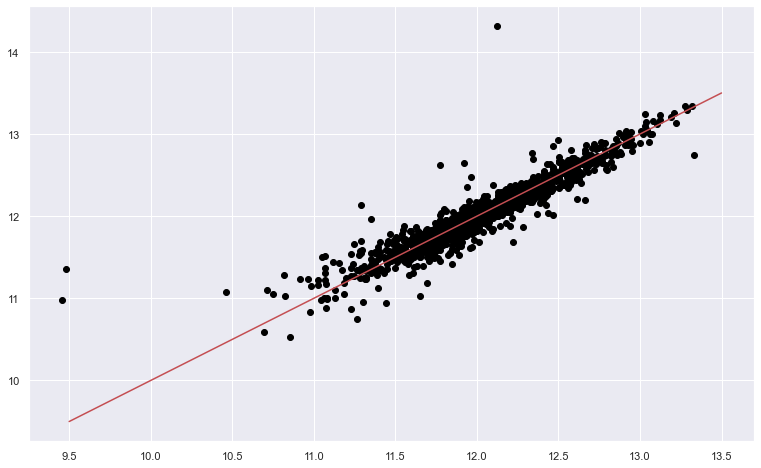

In [63]:
plt.figure(figsize=(13,8))
plt.scatter(np.log1p(answers['SalePrice']), pred, color='black')
plt.plot(np.linspace(9.5, 13.5, 2), np.linspace(9.5, 13.5, 2), c = 'r')